In [16]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import random
import shutil

In [17]:
project_path = r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project'
dir_train = 'train_videos'
np.random.seed(251)

In [18]:
class OpticalFlow(object):
    
    def __init__ (self, proj_path, in_dir, out_dir, video, upper_detection=True, crop = True, feature_quality=0.01):

        self.proj_path = proj_path
        self.in_dir = in_dir
        self.out_dir = out_dir
        self.video = video
        self.crop = crop
        
        if feature_quality < 0.0001: 
            # would encounter image naming issues
            raise ValueError('''feature_quality shouldn't be less than 0.0001''')
        elif feature_quality > 0.05:
            # goodFeaturesToTrack doesn't work well above 0.01
            raise ValueError('''feature_quality shouldn't be more than 0.01''')
        # Brady's video is very dark. In order to recognize features, I have to lower the feature_quality ten-fold
        if 'Brady' in self.video:            
            self.feature_quality = feature_quality/2
        else:
            self.feature_quality = feature_quality        
        
        self.cap = cv2.VideoCapture(os.path.join(proj_path, in_dir, video))
        self.ret, self.first_frame = self.cap.read()
        plt.imshow(self.first_frame)

        if upper_detection:
            self._detect_upper_body()
        else: 
            self.crop_x0, self.crop_y0 = 0, 0
            self.crop_y1, self.crop_x1, _ = self.first_frame.shape
        
        if self.crop:    
            self.first_frame = self.first_frame[self.crop_y0:self.crop_y1, self.crop_x0:self.crop_x1]
        self.prev_gray = cv2.cvtColor(self.first_frame,cv2.COLOR_BGR2GRAY)
        self.prev_corners = cv2.goodFeaturesToTrack(self.prev_gray, maxCorners=50,
                                                    qualityLevel=self.feature_quality, minDistance=10)
        
        self.frame = np.zeros_like(self.first_frame)
        self.mask = np.zeros_like(self.first_frame)
        self.frame_mask = np.zeros_like(self.first_frame)
        # green
        self.color = (0, 255, 0)
        
    def _detect_upper_body(self):
        face_cascade = cv2.CascadeClassifier(r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\haarcascade_frontalface_default.xml')
        face = face_cascade.detectMultiScale(self.first_frame, scaleFactor=1.3 , minNeighbors=7)
        for (x,y,w,h) in face:
            self.crop_x0 = x-w*2
            self.crop_x1 = x+w*3
            self.crop_y0 = y
            self.crop_y1 = y+h*4
            break
    
    def _process_one_frame(self):
        self.ret, self.frame = self.cap.read()
        # Converts each frame to grayscale - we previously only converted the first frame to grayscale
        if not self.ret:
            return
        if self.crop:
            self.frame = self.frame[self.crop_y0:self.crop_y1, self.crop_x0:self.crop_x1]
        gray = cv2.cvtColor(self.frame, cv2.COLOR_BGR2GRAY)
        # Calculates sparse optical flow by Lucas-Kanade method
        lk_params = dict(winSize = (15,15), maxLevel = 1, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
        # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowpyrlk
        next_corners, status, error = cv2.calcOpticalFlowPyrLK(self.prev_gray, gray, self.prev_corners, None, **lk_params)
        # Selects good feature points for previous position
        temp_prev = self.prev_corners[status == 1]
        # Selects good feature points for next position
        temp_next = next_corners[status == 1]
        prev_corners_good =[]
        for i in temp_prev:
            x,y = i.ravel()
            if self.crop_x0 <= x <= self.crop_x1 and self.crop_y0 <= y <= self.crop_y1:
                prev_corners_good.append(np.array([x,y]))
        prev_corners_good = np.array(prev_corners_good)
        next_corners_good =[]
        for i in temp_next:
            x,y = i.ravel()
            if self.crop_x0 <= x <= self.crop_x1 and self.crop_y0 <= y <= self.crop_y1:
                next_corners_good.append(np.array([x,y]))
        next_corners_good = np.array(next_corners_good)
        # Draws the optical flow tracks
        for i, (new, old) in enumerate(zip(next_corners_good, prev_corners_good)):
            # Returns a contiguous flattened array as (x, y) coordinates for new point
            a, b = new.ravel()
            # Returns a contiguous flattened array as (x, y) coordinates for old point
            c, d = old.ravel()
            # Draws line between new and old position with green color and 2 thickness
            self.mask = cv2.line(self.mask, (a, b), (c, d), self.color, 2)
            # Draws filled circle (thickness of -1) at new position with green color and radius of 3
            self.frame = cv2.circle(self.frame, (a, b), 3, self.color, -1)
        # Overlays the optical flow tracks on the original frame
        self.frame_mask = cv2.add(self.frame, self.mask)
        # Updates previous frame
        self.prev_gray = gray.copy()
        # Updates previous good feature points
        self.prev_corners = next_corners_good.reshape(-1, 1, 2)
        # Opens a new window and displays the output frame
        # cv2.imshow("sparse optical flow", output)
        #plt.imshow(self.output),plt.show()
        return True
        
    def process_all_frames(self):
        while self.cap.isOpened():
            if self._process_one_frame() is None :
                break
                
    def save_as_image(self, split=None, frame=False, transfer_dir=None):
        # Image name follows: [mask_ or frame_mask_]_[word]_c[counter]_ql[self.feature_quality*10000].png
        # Image name follows: [mask_ or frame_mask_]_[word]_c[counter]_[split]_ql[self.feature_quality*10000].png
        temp_segments = len(self.video.split('_'))
        word = self.video.split('_')[temp_segments-2-1]
        counter = self.video.split('_')[temp_segments-1].split('.')[0]
        ql = str(int(self.feature_quality*100000))
        if split is None :
            plt.imsave(os.path.join(self.proj_path, self.out_dir, 'mask_' + word + '_c' + counter + '_ql' + ql + '.png'),
                       self.mask)
            if frame:
                plt.imsave(os.path.join(self.proj_path, self.out_dir, 'framemask_' + word + '_c' + counter + '_ql' + ql + '.png'),
                           self.frame_mask)
        else:
            plt.imsave(os.path.join(self.proj_path, self.out_dir, 'mask_' + word + '_c' + counter + '_' + split + '_ql' + ql + '.png'),
                       self.mask)
            if frame:
                plt.imsave(os.path.join(self.proj_path, self.out_dir, 'framemask_' + word + '_c' + counter + '_' + split + '_ql' + ql + '.png'),
                           self.frame_mask)
        if transfer_dir is not None:
            plt.imsave(os.path.join(self.proj_path, transfer_dir, word, 'mask_' + word + '_c' + counter + '_ql' + ql + '.png'),
                       self.mask)
            if frame:
                plt.imsave(os.path.join(self.proj_path, transfer_dir, word, 'framemask_' + word + '_c' + counter + '_ql' + ql + '.png'),
                           self.frame_mask)


(480, 640, 3)


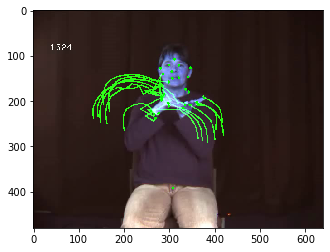

In [19]:
# Example 1 - AGAIN
test_class = OpticalFlow(proj_path=project_path, in_dir=dir_train, 
                         out_dir='train_optical_flow_output', 
                         video='ASL_2006_10_10_scene2-camera1_AGAIN_v0_9.mov', 
                         crop=False)

# for i in range(0, 3):
#     test_class._process_one_frame()
#     plt.imshow(test_class.frame_mask), plt.show()

test_class.process_all_frames()
plt.imshow(test_class.frame_mask)
print(test_class.frame_mask.shape)
test_class.save_as_image()
test_class.cap.release()
del test_class

(332, 415, 3)


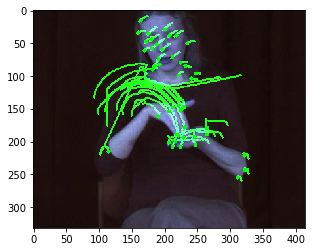

In [9]:
# Example 2 - AGAIN
test_class = OpticalFlow(proj_path=project_path, in_dir=dir_train, 
                          out_dir='train_optical_flow_output', 
                          video='ASL_2008_01_11_scene9-camera1_AGAIN_v0_0.mov',
                          feature_quality=0.01)

# for i in range(0, 3):
#     test_class._process_one_frame()
#     plt.imshow(test_class.frame_mask), plt.show()

test_class.process_all_frames()
plt.imshow(test_class.frame_mask)
print(test_class.frame_mask.shape)
test_class.save_as_image()
test_class.cap.release()
cv2.destroyAllWindows()
del test_class

(356, 445, 3)


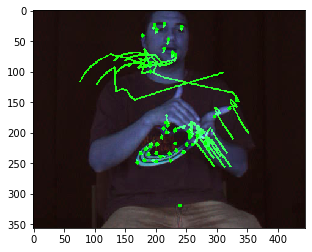

In [5]:
# Example 3 - AGAIN
test_class = OpticalFlow(proj_path=project_path, in_dir=dir_train, 
                          out_dir='train_optical_flow_output', 
                          video='ASL_2008_05_12a_scene8-camera1_AGAIN_v0_2.mov',
                          feature_quality=0.0001)

# for i in range(0, 3):
#     test_class._process_one_frame()
#     plt.imshow(test_class.frame_mask), plt.show()

test_class.process_all_frames()
plt.imshow(test_class.frame_mask)
print(test_class.frame_mask.shape)
test_class.save_as_image()
test_class.cap.release()
cv2.destroyAllWindows()
del test_class

(264, 330, 3)


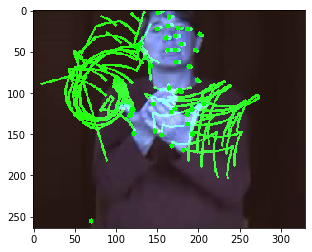

In [6]:
# Example 4 - ALL
test_class = OpticalFlow(proj_path=project_path, in_dir=dir_train, 
                          out_dir='train_optical_flow_output', 
                          video='ASL_2006_10_10_scene2-camera1_ALL_v0_4.mov')

# for i in range(0, 3):
#     test_class._process_one_frame()
#     plt.imshow(test_class.frame_mask), plt.show()

test_class.process_all_frames()
plt.imshow(test_class.frame_mask)
print(test_class.frame_mask.shape)
test_class.save_as_image()
test_class.cap.release()
cv2.destroyAllWindows()
del test_class

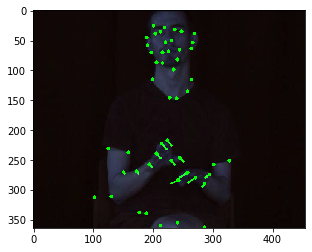

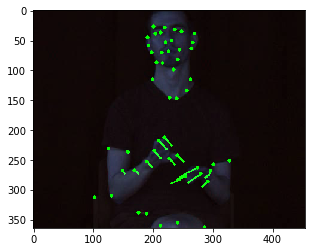

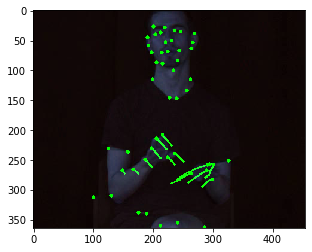

In [7]:
# debug
test_class = OpticalFlow(proj_path=project_path, in_dir=dir_train, 
                          out_dir='train_optical_flow_output', 
                          video='ASL_2011_06_08_Brady_scene18-camera1_BEHAVIOR_v1_4.mov',
                         feature_quality=0.0086)

for i in range(0, 3):
    test_class._process_one_frame()
    plt.imshow(test_class.frame_mask), plt.show()

# test_class.process_all_frames()
# plt.imshow(test_class.frame_mask)

# test_class.save_as_image()
# test_class.cap.release()
# cv2.destroyAllWindows()
# del test_class


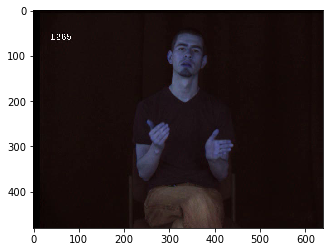

In [14]:
# # Run OpticalFlow + save image as either train or val
# 
# # # select a sample count between 1 and 100
# sample_lower = 1
# sample_higher = 100
# sample_count = 100
# val_pct = 0.4
# 
# if 0 < sample_count <= sample_higher - sample_lower:
#     # Sample x number of integers from 1 to 100
#     # sample_arr = np.add(random.sample(range(100), sample_count), 1)
#     sample_arr = np.random.choice(range(sample_lower, sample_higher+1), sample_count, replace=False)
# elif sample_count > sample_higher - sample_lower:
#     sample_arr = np.add(np.array(range(sample_count)), 1)
# else:
#     raise ValueError('sample_count is below zero')
# 
# ql_arr = np.divide(sample_arr, 10000)
# 
# val_count = max(int(sample_count*val_pct), 1)
# val_index_arr = np.random.choice(range(sample_count), val_count, replace=False)
# 
# # List all the .mov files in dir_train
# # The following two loops should create 92(# of training videos)*[sample_count]*2 images
# # files_mov_lst = [f for f in os.listdir(os.path.join(project_path, dir_train)) if f[-4:]=='.mov']
# files_mov_lst = ['ASL_2011_06_14_Brady_scene2-camera1_AGAIN_v3_7.mov']
# for f in files_mov_lst:
#     for i, ql in enumerate(ql_arr):
#         test_class = OpticalFlow(proj_path=project_path, in_dir=dir_train, 
#                                   out_dir='train_optical_flow_output', 
#                                   video=f,
#                                   feature_quality=ql)
#         test_class.process_all_frames()    
#         if i in val_index_arr:
#             test_class.save_as_image(split='val')
#         else:
#             test_class.save_as_image(split='train')
#         test_class.cap.release()
#         cv2.destroyAllWindows()

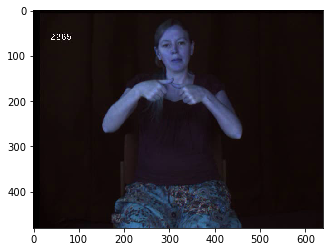

In [20]:
shutil.rmtree(os.path.join(project_path, out_dir))
os.mkdir(os.path.join(project_path, out_dir))
# Run OpticalFlow + save image as either train or val
# 100 ql choices per video is too big to load into memory on my local machine
# select a sample count between 1 and 100
sample_lower = 100
sample_higher = 500
sample_count = 2
val_pct = 0.4

if 0 < sample_count <= sample_higher - sample_lower:
    # Sample x number of integers from 1 to 100
    # sample_arr = np.add(random.sample(range(100), sample_count), 1)
    sample_arr = np.random.choice(range(sample_lower, sample_higher+1), sample_count, replace=False)
elif sample_count > sample_higher - sample_lower:
    sample_arr = np.add(np.array(range(sample_count)), 1)
else:
    raise ValueError('sample_count is below zero')

ql_arr = np.divide(sample_arr, 10000)

val_count = max(int(sample_count*val_pct), 1)
val_index_arr = np.random.choice(range(sample_count), val_count, replace=False)

# List all the .mov files in dir_train
# The following two loops should create 92(# of training videos)*[sample_count]*2 images
files_mov_lst = [f for f in os.listdir(os.path.join(project_path, dir_train)) if f[-4:]=='.mov' and 'Brady' not in f]
for f in files_mov_lst:
    for i, ql in enumerate(ql_arr):
        test_class = OpticalFlow(proj_path=project_path, in_dir=dir_train, 
                                  out_dir='train_optical_flow_output_nocrop_2', 
                                  video=f,
                                  crop=False,
                                  feature_quality=ql)
        test_class.process_all_frames()    
        if i in val_index_arr:
            test_class.save_as_image(split='val')
        else:
            test_class.save_as_image(split='train')
        test_class.cap.release()
        cv2.destroyAllWindows()

In [17]:
# verify all videos are processed
# It's not true, but I am going to ignore this problem for now.
test_file_count = dict()
test_all_files = [f for f in os.listdir(os.path.join(project_path, 'train_optical_flow_output'))]
for f in test_all_files:
    test_unique_video = f.split('_')[1] + '_' + f.split('_')[2]
    test_file_count[test_unique_video] = test_file_count.get(test_unique_video, 0) + 1

In [18]:
test_file_count

{'AGAIN_c0': 200,
 'AGAIN_c2': 200,
 'AGAIN_c3': 200,
 'AGAIN_c4': 200,
 'AGAIN_c7': 186,
 'AGAIN_c8': 182,
 'AGAIN_c9': 200,
 'ALL_c1': 200,
 'ALL_c2': 200,
 'ALL_c4': 200,
 'ALL_c5': 200,
 'AWKWARD_c0': 200,
 'AWKWARD_c1': 200,
 'AWKWARD_c2': 200,
 'AWKWARD_c3': 184,
 'BASEBALL_c1': 200,
 'BEHAVIOR_c0': 200,
 'BEHAVIOR_c1': 200,
 'BEHAVIOR_c2': 200,
 'BEHAVIOR_c4': 184,
 'CAN_c1': 200,
 'CAN_c3': 200,
 'CAN_c4': 184,
 'CAN_c6': 200,
 'CAN_c7': 200,
 'CHAT_c1': 200,
 'CHAT_c2': 200,
 'CHAT_c4': 200,
 'CHAT_c5': 200,
 'CHAT_c8': 200,
 'CHAT_c9': 200,
 'CHEAP_c0': 200,
 'CHEAP_c1': 200,
 'CHEAP_c4': 200,
 'CHEAP_c5': 200,
 'CHEAT_c0': 200,
 'CHEAT_c2': 200,
 'CHEAT_c3': 200,
 'CHURCH_c0': 200,
 'CHURCH_c3': 184,
 'CHURCH_c4': 200,
 'CHURCH_c5': 200,
 'COAT_c1': 200,
 'COAT_c2': 200,
 'COAT_c4': 200,
 'COAT_c5': 200,
 'CONFLICT_c0': 200,
 'CONFLICT_c2': 200,
 'CONFLICT_c3': 200,
 'CONFLICT_c4': 184,
 'CONFLICT_c6': 182,
 'CONFLICT_c7': 200,
 'COURT_c2': 200,
 'COURT_c3': 200,
 'COURT_c5'

In [21]:
# verify all videos are processed
test_file_count = dict()
test_all_files = [f for f in os.listdir(os.path.join(project_path, 'train_optical_flow_output_10'))]
for f in test_all_files:
    test_unique_video = f.split('_')[1] + '_' + f.split('_')[2]
    test_file_count[test_unique_video] = test_file_count.get(test_unique_video, 0) + 1
    

In [22]:
test_file_count

{'AGAIN_c0': 20,
 'AGAIN_c2': 20,
 'AGAIN_c3': 20,
 'AGAIN_c4': 20,
 'AGAIN_c7': 20,
 'AGAIN_c8': 20,
 'AGAIN_c9': 20,
 'ALL_c1': 20,
 'ALL_c2': 20,
 'ALL_c4': 20,
 'ALL_c5': 20,
 'AWKWARD_c0': 20,
 'AWKWARD_c1': 20,
 'AWKWARD_c2': 20,
 'AWKWARD_c3': 20,
 'BASEBALL_c1': 20,
 'BEHAVIOR_c0': 20,
 'BEHAVIOR_c1': 20,
 'BEHAVIOR_c2': 20,
 'BEHAVIOR_c4': 20,
 'CAN_c1': 20,
 'CAN_c3': 20,
 'CAN_c4': 20,
 'CAN_c6': 20,
 'CAN_c7': 20,
 'CHAT_c1': 20,
 'CHAT_c2': 20,
 'CHAT_c4': 20,
 'CHAT_c5': 20,
 'CHAT_c8': 20,
 'CHAT_c9': 20,
 'CHEAP_c0': 20,
 'CHEAP_c1': 20,
 'CHEAP_c4': 20,
 'CHEAP_c5': 20,
 'CHEAT_c0': 20,
 'CHEAT_c2': 20,
 'CHEAT_c3': 20,
 'CHURCH_c0': 20,
 'CHURCH_c3': 20,
 'CHURCH_c4': 20,
 'CHURCH_c5': 20,
 'COAT_c1': 20,
 'COAT_c2': 20,
 'COAT_c4': 20,
 'COAT_c5': 20,
 'CONFLICT_c0': 20,
 'CONFLICT_c2': 20,
 'CONFLICT_c3': 20,
 'CONFLICT_c4': 20,
 'CONFLICT_c6': 20,
 'CONFLICT_c7': 20,
 'COURT_c2': 20,
 'COURT_c3': 20,
 'COURT_c5': 20,
 'COURT_c6': 20,
 'COURT_c7': 20,
 'COURT_c8': 2

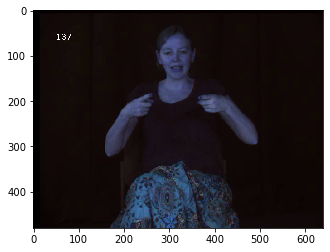

In [22]:
# Run OpticalFlow + save image as either train or val
# 100 ql choices per video is too big to load into memory on my local machine
# select a sample count between 1 and 100
sample_lower = 100
sample_higher = 300
sample_count = 2
val_pct = 0.4

if 0 < sample_count <= sample_higher - sample_lower:
    # Sample x number of integers from 1 to 100
    # sample_arr = np.add(random.sample(range(100), sample_count), 1)
    sample_arr = np.random.choice(range(sample_lower, sample_higher+1), sample_count, replace=False)
elif sample_count > sample_higher - sample_lower:
    sample_arr = np.add(np.array(range(sample_count)), 1)
else:
    raise ValueError('sample_count is below zero')
ql_arr = np.divide(sample_arr, 10000)

# List all the .mov files in dir_train
# The following two loops should create 50(# of training videos)*[sample_count]*2 images
files_mov_lst = [f for f in os.listdir(os.path.join(project_path, 'val_videos')) if f[-4:]=='.mov' and 'Brady' not in f]
for f in files_mov_lst:
    for i, ql in enumerate(ql_arr):
        test_class = OpticalFlow(proj_path=project_path, in_dir='val_videos', 
                                  out_dir='val_optical_flow_output_nocrop_2', 
                                  video=f,
                                  crop=False,
                                  feature_quality=ql)
        test_class.process_all_frames()    
        test_class.save_as_image()
        test_class.cap.release()
        cv2.destroyAllWindows()



In [13]:
# verify all videos are processed
test_file_count = dict()
test_all_files = [f for f in os.listdir(os.path.join(project_path, 'val_optical_flow_output_10'))]
for f in test_all_files:
    test_unique_video = f.split('_')[1] + '_' + f.split('_')[2]
    test_file_count[test_unique_video] = test_file_count.get(test_unique_video, 0) + 1
    

In [14]:
test_file_count




{'AGAIN_c10': 20,
 'AGAIN_c1': 20,
 'AGAIN_c5': 20,
 'AGAIN_c6': 20,
 'ALL_c0': 20,
 'ALL_c3': 20,
 'AWKWARD_c4': 20,
 'AWKWARD_c5': 20,
 'BASEBALL_c0': 20,
 'BEHAVIOR_c3': 20,
 'BEHAVIOR_c5': 20,
 'CAN_c0': 20,
 'CAN_c2': 20,
 'CAN_c5': 20,
 'CHAT_c0': 20,
 'CHAT_c3': 20,
 'CHAT_c6': 20,
 'CHAT_c7': 20,
 'CHEAP_c2': 20,
 'CHEAP_c3': 20,
 'CHEAT_c1': 20,
 'CHEAT_c4': 20,
 'CHURCH_c1': 20,
 'CHURCH_c2': 20,
 'COAT_c0': 20,
 'COAT_c3': 20,
 'CONFLICT_c1': 20,
 'CONFLICT_c5': 20,
 'CONFLICT_c8': 20,
 'COURT_c0': 20,
 'COURT_c1': 20,
 'COURT_c4': 20,
 'DEPOSIT_c2': 20,
 'DEPOSIT_c3': 20,
 'DEPRESS_c3': 20,
 'DEPRESS_c4': 20,
 'DOCTOR_c1': 20,
 'DOCTOR_c4': 20,
 'DOCTOR_c5': 20,
 'DRESS_c14': 20,
 'DRESS_c16': 20,
 'DRESS_c18': 20,
 'DRESS_c1': 20,
 'DRESS_c3': 20,
 'DRESS_c5': 20,
 'DRESS_c9': 20,
 'ENOUGH_c2': 20,
 'ENOUGH_c5': 20,
 'NEG_c1': 20,
 'NEG_c3': 20}

In [23]:
import shutil

shutil.rmtree(os.path.join(project_path, 'test'))
os.mkdir(os.path.join(project_path, 'test'))

